In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
from scipy import interpolate as interp
from scipy.integrate import quad
from scipy.misc import derivative

omega0 = 0.3
rho = 2.78e11 * omega0 #(h**(-1) * M_sol)(h**(-1) * Mpc)**(-3)
delta = 1.68
h = 0.678

logk_data, logPk_data = np.loadtxt("pk2.dat", unpack=True)
kData = 10.**logk_data
PkData = 10.**logPk_data

P = interp.UnivariateSpline(kData, PkData, s = 0, ext = 1)

def W(x):
    return (3. * (np.sin(x) - x * np.cos(x)) / (x**3))

def r(m):
    M = m / h #converting from units of M_sol to h**(-1) * M_sol
    return (3. * m / (4. * np.pi * rho))**(1./3.)

def sigma2(M):
    R = r(M)
    def integrand(k):
        return (W(k * R)**2 * P(k) * k**2)
    
    def integrand2(t):
        k = (1. + t) / (1. - t)
        return integrand(k) * 2. / ((1 - t)**2)
    if isinstance(M, np.ndarray):
        integral = []
        for m in M:
            R = r(m)
            integral.append(quad(integrand2, -1., 1.)[0])
        integral = np.asarray(integral)
    else:
        (integral, error) = quad(integrand2, -1., 1.)
        
    A = 1./ (2. * np.pi**2)
    return A * integral


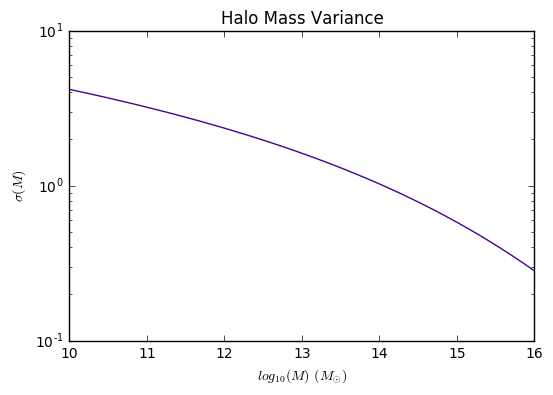

/Users/Jacob/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/Jacob/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


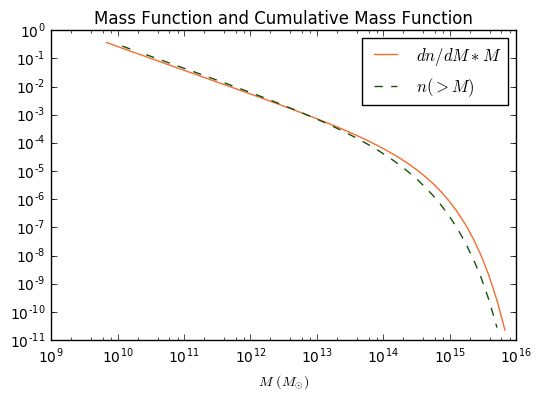

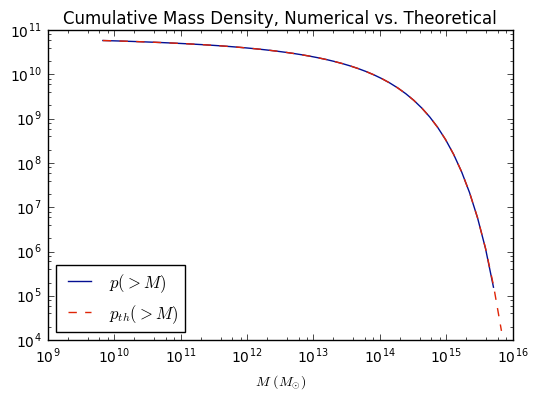

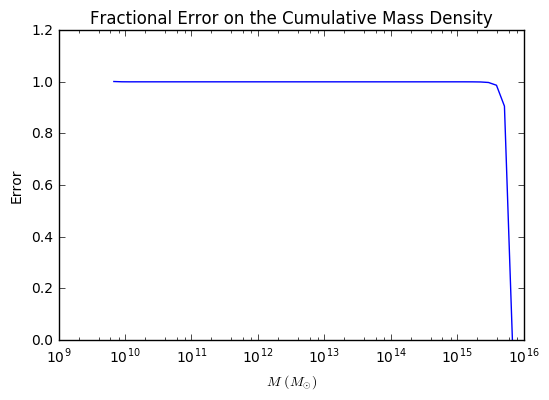

In [4]:
def main():
    expRange = np.linspace(10., 16.)
    sigmas = []
    for exp in expRange:
        sigmas.append(np.sqrt(sigma2(10.**exp)))
    sigmas = np.asarray(sigmas)
    
    #Create new Mass ranges
    lnMRange = np.linspace(np.log(10**10), np.log(10**16), 51)
    MRange = np.exp(lnMRange) * h #Now in units of M_sol
    
    #Interpolate sigma as a function of ln(M)
    SigmaLn = interp.UnivariateSpline(np.log(10**expRange), np.log(sigmas), s = 0, ext = 0)
    SigmaLnPrime = SigmaLn.derivative()
    SigmaM = interp.UnivariateSpline(10**expRange, sigmas, s = 0, ext = 0) #Useful to have so we don't have to keep doing quad whenever we want sigma
    SigmaMPrime = SigmaM.derivative()
    
    
    def dndM(M): 
        lnM = np.log(M)
        v = delta / SigmaM(M)
        dlnsigma_dlnm = SigmaLnPrime(lnM)
        return -np.sqrt(2. / np.pi) * (rho / M**2) * v * dlnsigma_dlnm * np.exp(-(v**2) / 2.)
    
    def dndM_M(M):
        lnM = np.log(M)
        v = delta / SigmaM(M)
        dlnsigma_dlnm = SigmaLnPrime(lnM)
        return -np.sqrt(2. / np.pi) * (rho / M) * v * dlnsigma_dlnm * np.exp(-(v**2) / 2.)
    
    def n(M): #Defining the Cumulative Mass Function
        if isinstance(M, np.ndarray): #allows n(M) to deal with arrays
            result = []
            for m in M:
                result.append(quad(dndM, m, M[-1])[0])
            result = np.asarray(result)
        else:
            (result, error) = quad(dndM, M, np.inf)
        return result
    
    def p(M): #defining the Cumulative Mass Density
        if isinstance(M, np.ndarray):
            result = []
            for m in M:
                result.append(quad(dndM_M, m, M[-1])[0])
            result = np.asarray(result)
        else:
            (result, error) = quad(dndM_M, M, np.inf)
        return result
    
    def F(M):
        return (1. - erf(delta / (np.sqrt(2. * SigmaM(M)**2))))
    
    #Plot sigma(M) vs log(M)
    plt.figure(0) 
    plt.semilogy(expRange, sigmas, c = '#450492')
    plt.xlabel('$log_{10}(M)$ $(M_{\odot})$')
    plt.ylabel('$\sigma(M)$')
    plt.title('Halo Mass Variance')
    plt.show()
    
    #Plot dn/dm * M
    dndmRange = []
    for M in MRange:
        dndmRange.append(dndM_M(M))
    dndmRange = np.asarray(dndmRange)
    plt.figure(1)
    plt.loglog(MRange, dndmRange, c = '#F36D2F', label = '$dn/dM * M$')\
    
    #plot n(>M)
    plt.figure(1)
    nRange = n(MRange)
    plt.loglog(MRange, nRange, c = '#17520B', ls = '--', label = '$n(>M)$')
    plt.xlabel('$M$ $(M_{\odot})$')
    plt.title('Mass Function and Cumulative Mass Function')
    plt.legend(loc = 0)
    plt.show()
    
    #plot p(>M)
    plt.figure(2)
    theoryRange = rho * F(MRange)
    plt.loglog(MRange, p(MRange), c = '#040F92', label = '$p(>M)$')
    plt.loglog(MRange, theoryRange, c = '#DF2406', ls = '--', label = '$p_{th}(>M)$')
    plt.xlabel('$M$ $(M_{\odot})$')
    plt.title('Cumulative Mass Density, Numerical vs. Theoretical')
    plt.legend(loc = 0)
    plt.show()
    
    #plot Error
    plt.figure(3)
    plt.semilogx(MRange, p(MRange) / theoryRange)
    plt.xlabel('$M$ $(M_{\odot})$')
    plt.ylabel('Error')
    plt.title('Fractional Error on the Cumulative Mass Density')
    plt.show()

if __name__ == '__main__':
    main()

In [27]:
print np.inf

inf


In [13]:
print isinstance(5, np.ndarray)

False
